In [1]:
from pyspark.sql import SparkSession
import os
from search import Search
from plotting import Plotting

os.environ["PYTHONUNBUFFERED"] = "1"
# os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

E:\Users\Sam\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\Users\Sam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
E:\Users\Sam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
E:\Users\Sam\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def read(spark):
    datasets = {}
    for dataset in os.listdir("./ml-latest-small"):
        data = spark.read.option("header", True).format("csv").load(os.path.join(os.getcwd(),"ml-latest-small",dataset))
        datasets[dataset.split('.')[0]]=data
    return datasets

In [3]:
spark = SparkSession.builder.master("local").appName("Movies").config("conf-key", "conf-value").getOrCreate()
datasets = read(spark)

In [4]:
plotting = Plotting(datasets, spark)
search = Search(datasets, spark)

Search user by id, show the number of movies/genre that he/she has watched

In [5]:
search.search_user_movies('1')

232

In [5]:
search.search_user_genre('1').show()

+---------+------------------+-------+
|   genres|       avg(rating)|watched|
+---------+------------------+-------+
|    Crime| 4.355555555555555|     45|
|  Romance|4.3076923076923075|     26|
| Thriller|4.1454545454545455|     55|
|Adventure|4.3882352941176475|     85|
|    Drama| 4.529411764705882|     68|
|      War|               4.5|     22|
|  Fantasy| 4.297872340425532|     47|
|  Mystery| 4.166666666666667|     18|
|  Musical| 4.681818181818182|     22|
|Animation| 4.689655172413793|     29|
|Film-Noir|               5.0|      1|
|   Horror|3.4705882352941178|     17|
|  Western| 4.285714285714286|      7|
|   Comedy|  4.27710843373494|     83|
| Children|4.5476190476190474|     42|
|   Action| 4.322222222222222|     90|
|   Sci-Fi|             4.225|     40|
+---------+------------------+-------+



Given a list of users, search all movies watched by each user

In [5]:
search.search_users_movies(["1","2","3"]).show()

+------+------+--------+
|genres|userId|count(1)|
+------+------+--------+
+------+------+--------+



Search movie by id/title, show the average rating, the number of users that have
watched the movie

In [8]:
search.search_movie(id="1").show()

+-------+------------------+--------+----------------+
|movieId|       avg(rating)|count(1)|           title|
+-------+------------------+--------+----------------+
|      1|3.9209302325581397|     215|Toy Story (1995)|
+-------+------------------+--------+----------------+



In [9]:
search.search_movie(name="Toy Story").show()

+-------+------------------+--------+------------------+
|movieId|       avg(rating)|count(1)|             title|
+-------+------------------+--------+------------------+
|   3114|3.8608247422680413|      97|Toy Story 2 (1999)|
|      1|3.9209302325581397|     215|  Toy Story (1995)|
|  78499| 4.109090909090909|      55|Toy Story 3 (2010)|
+-------+------------------+--------+------------------+



Search genre, show all movies in that genre

In [10]:
search.search_genre("Action").show(10,False)

+-------+-----------------------------------------+----------------------------------+
|movieId|title                                    |genres                            |
+-------+-----------------------------------------+----------------------------------+
|6      |Heat (1995)                              |Action|Crime|Thriller             |
|9      |Sudden Death (1995)                      |Action                            |
|10     |GoldenEye (1995)                         |Action|Adventure|Thriller         |
|15     |Cutthroat Island (1995)                  |Action|Adventure|Romance          |
|20     |Money Train (1995)                       |Action|Comedy|Crime|Drama|Thriller|
|23     |Assassins (1995)                         |Action|Crime|Thriller             |
|42     |Dead Presidents (1995)                   |Action|Crime|Drama                |
|44     |Mortal Kombat (1995)                     |Action|Adventure|Fantasy          |
|66     |Lawnmower Man 2: Beyond Cyberspace

Given a list of genres, search all movies belonging to each genre

In [7]:
[i.show(3, False) for i in search.search_genres(["Action","Romance"])]
# search.search_genres(["Action","Romance"]).show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     17|Sense and Sensibi...|       Drama|Romance|
|     20|  Money Train (1995)|Action|Comedy|Cri...|
|     23|    Assassins (1995)|Action|Crime|Thri...|
|     25|Leaving Las Vegas...|       Drama|Romance|
|     28|   Persuasion (1995)|       Drama|Romance|
|     39|     Clueless (1995)|      Comedy|Romance|
|     42|Dead Presidents (...|  Action|Crime|Drama|
|     44|Mortal Kombat (1995)|Action|Adventure|...|
|     46|How

Search movies by year

In [12]:
search.search_movie_year("1995").show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

List the top n movies with highest rating, ordered by the rating

In [5]:
search.list_rating(5).show(truncate=False)

AnalysisException: cannot resolve '`watched`' given input columns: [avg(rating), movies.genres, ratings.movieId, movies.title];;
'Sort [avg(rating)#151 DESC NULLS LAST, 'watched DESC NULLS LAST], true
+- Project [movieId#85, avg(rating)#151, title#63, genres#64]
   +- Join Inner, (movieId#85 = movieId#62)
      :- Aggregate [movieId#85], [movieId#85, avg(cast(rating#121 as double)) AS avg(rating)#151]
      :  +- SubqueryAlias ratings
      :     +- Project [userId#84, movieId#85, cast(rating#86 as float) AS rating#121, timestamp#87]
      :        +- Relation[userId#84,movieId#85,rating#86,timestamp#87] csv
      +- SubqueryAlias movies
         +- Relation[movieId#62,title#63,genres#64] csv


List the top n movies with the highest number of watches, ordered by the number of
watches

In [6]:
search.list_watches(5).show(truncate=False)

AnalysisException: cannot resolve '`movies.movieId`' given input columns: [ratings.movieId, ratings.rating, ratings.timestamp, ratings.userId];;
'Aggregate ['movies.movieId], ['movies.movieId, count(1) AS watches#164L]
+- SubqueryAlias ratings
   +- Project [userId#84, movieId#85, cast(rating#86 as float) AS rating#121, timestamp#87]
      +- Relation[userId#84,movieId#85,rating#86,timestamp#87] csv


Find the favourite genre of a given user, or group of users. Consider and justify how
you will define ‘favourite’.

In [15]:
search.search_user_favourites("1").show(10,False)

+---------+------------------+
|genres   |score             |
+---------+------------------+
|Action   |4.322222222222222 |
|Adventure|4.142494117647059 |
|Comedy   |3.9392168674698795|
|Drama    |3.410647058823529 |
|Thriller |2.516290909090909 |
|Fantasy  |2.222             |
|Crime    |2.151644444444444 |
|Children |2.096452380952381 |
|Sci-Fi   |1.85055           |
|Animation|1.4772413793103447|
+---------+------------------+
only showing top 10 rows



Compare the movie tastes of two users. Consider and justify how you will compare
and present the data.

In [16]:
search.compare_users("477", "610").show()

+-----------------+
|       similarity|
+-----------------+
|71.18257257802378|
+-----------------+



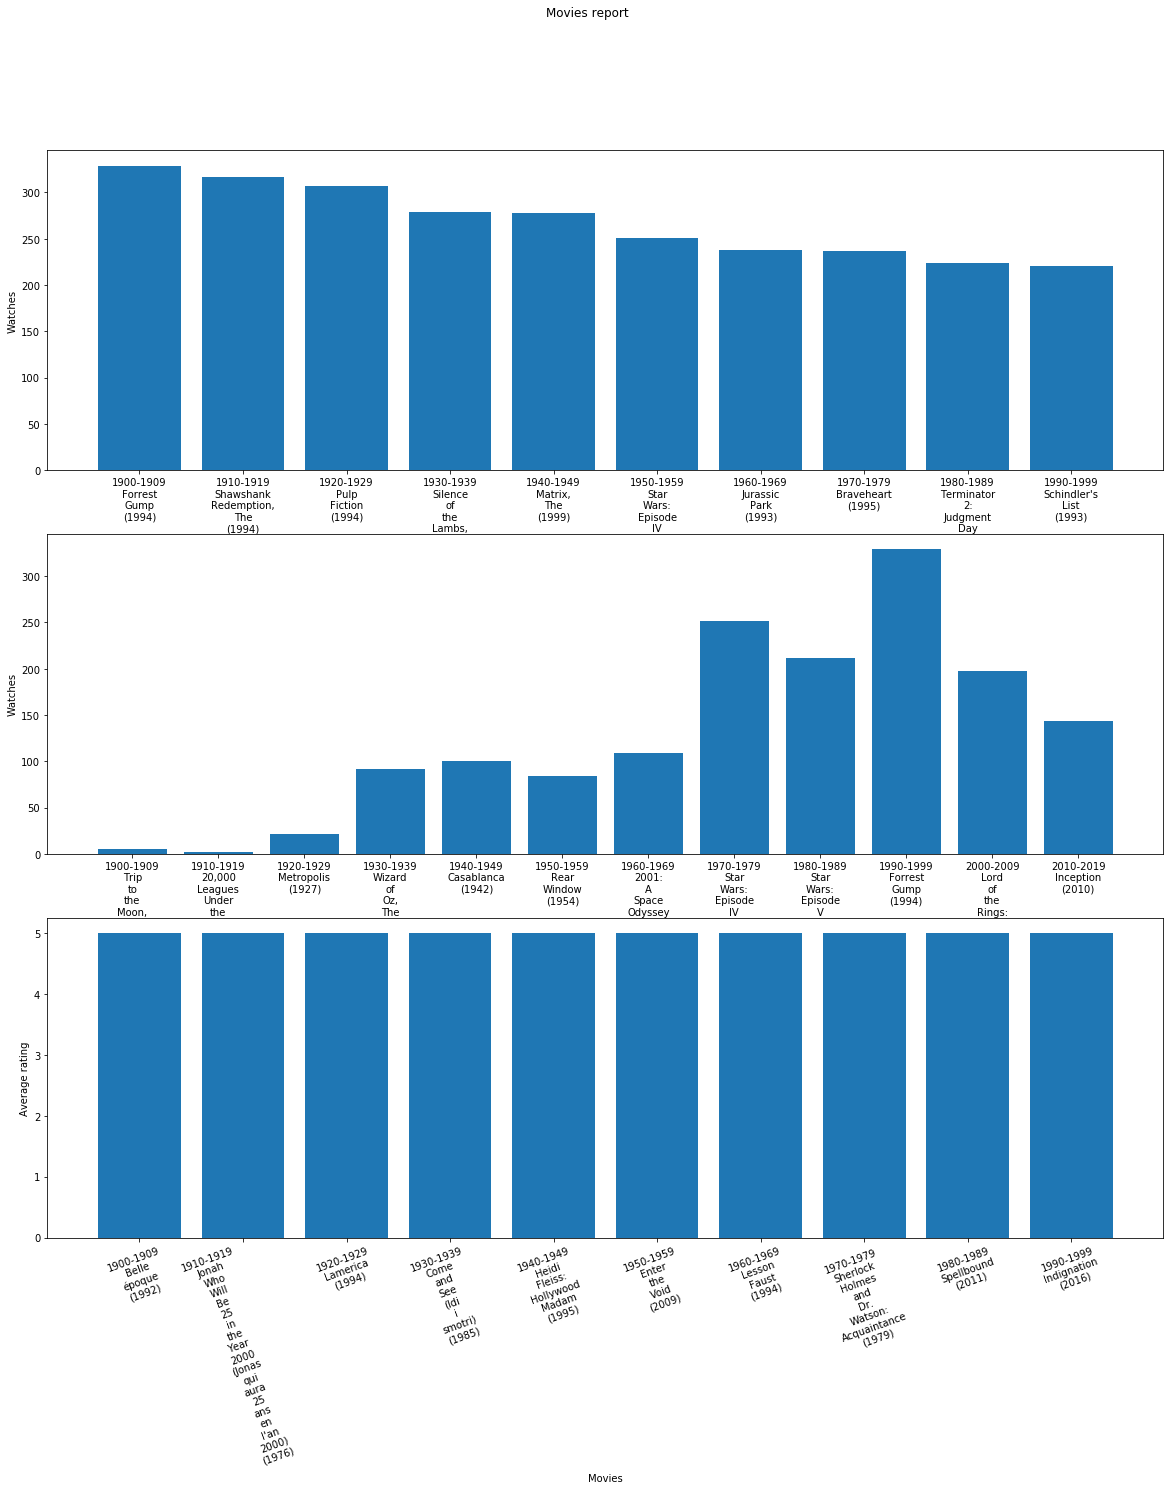

In [6]:
plotting.gen_movies_report()

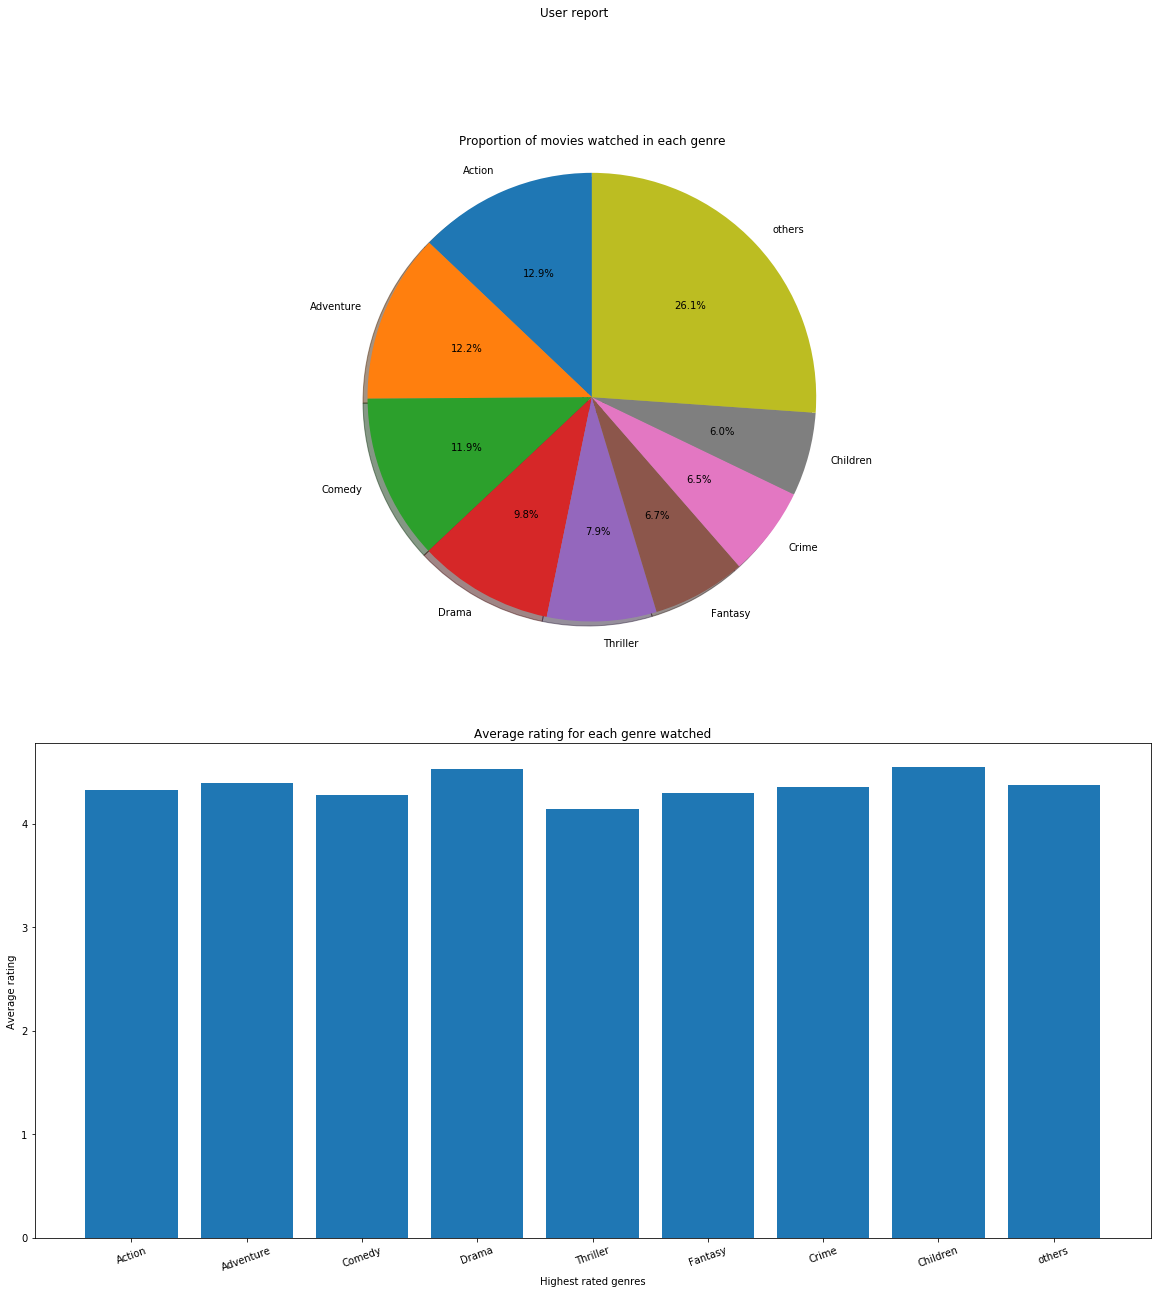

In [5]:
plotting.gen_user_report("1")

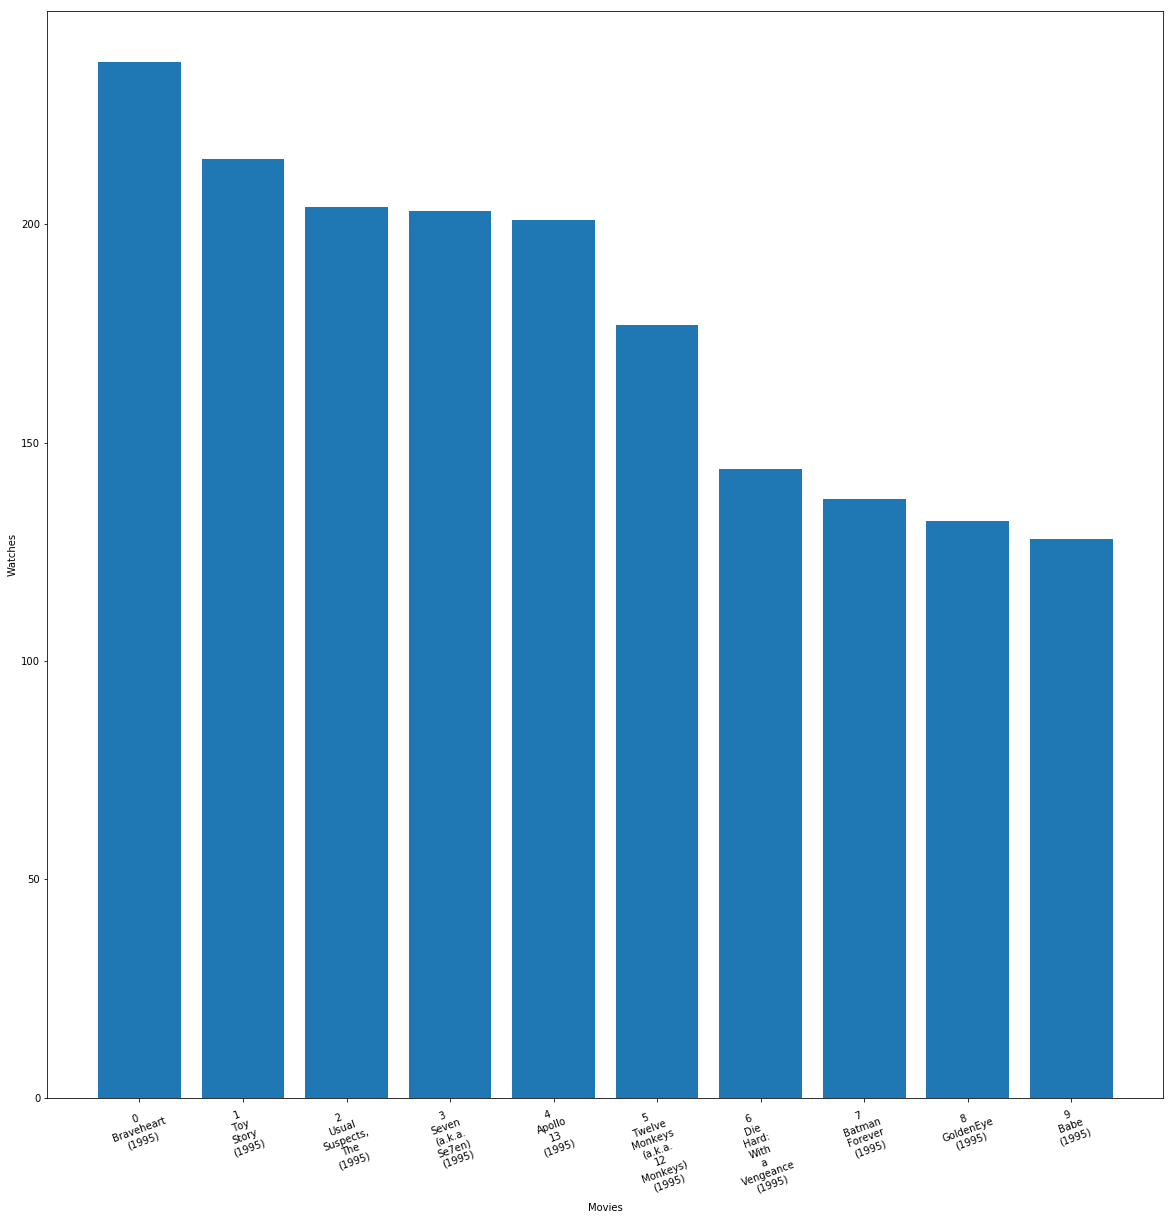

In [6]:
plotting.gen_most_watched_year("1995", 10)

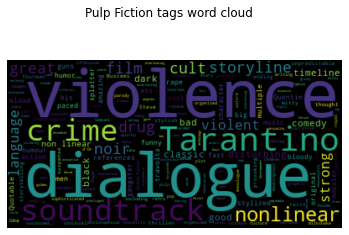

In [20]:
plotting.gen_movie_wordcloud("Pulp Fiction")

Recommend movies for a set of users

In [6]:
search.recommend_n_movies_for_users(5, ["1", "3", "47", "235"]).show(truncate=False)

+------+------------------------------------------------+
|userId|title                                           |
+------+------------------------------------------------+
|47    |Coco (2017)                                     |
|47    |Thin Red Line, The (1998)                       |
|47    |Detroit Rock City (1999)                        |
|47    |How to Train Your Dragon 2 (2014)               |
|47    |Center Stage (2000)                             |
|1     |Battlestar Galactica (2003)                     |
|1     |Cabin in the Woods, The (2012)                  |
|1     |The Raid: Redemption (2011)                     |
|1     |Gosford Park (2001)                             |
|1     |Grave of the Fireflies (Hotaru no haka) (1988)  |
|3     |I Now Pronounce You Chuck and Larry (2007)      |
|3     |Pirate Radio (2009)                             |
|3     |Jackass Number Two (2006)                       |
|3     |The Interview (2014)                            |
|3     |Observ

In [7]:
search.recommend_n_movies_for_users(5, ["1"]).show(truncate=False)


+------+-----------------------------------+
|userId|title                              |
+------+-----------------------------------+
|1     |Bottle Rocket (1996)               |
|1     |Split (2017)                       |
|1     |Waking Life (2001)                 |
|1     |Eraserhead (1977)                  |
|1     |Guess Who's Coming to Dinner (1967)|
+------+-----------------------------------+

